In [4]:
import numpy as np
from pathlib import Path

p = "../diffusion_model/run_2/condition_2.npz"
if not Path(p).exists(): raise FileNotFoundError(p)

z = np.load(p, allow_pickle=True)
    
print("keys:", z.files)
for k in z.files:
    v = z[k]
    if isinstance(v, np.ndarray) and v.dtype == object and v.shape == ():
        o = v.item()
        if isinstance(o, dict): print(k, "->", list(o.keys()))
    elif isinstance(v, dict):
        print(k, "->", list(v.keys()))
    elif isinstance(v, np.ndarray) and v.dtype == object:
        for i, e in enumerate(v.flat):
            if isinstance(e, dict): print(f"{k}[{i}] ->", list(e.keys()))


keys: ['bundle']
bundle -> ['input', 'target', 'output', 'meta']


In [23]:
bundle_dict = z['bundle'].item()

In [37]:
bundle_dict['target'].min(), bundle_dict['target'].max()

(np.float32(0.0), np.float32(1.0))

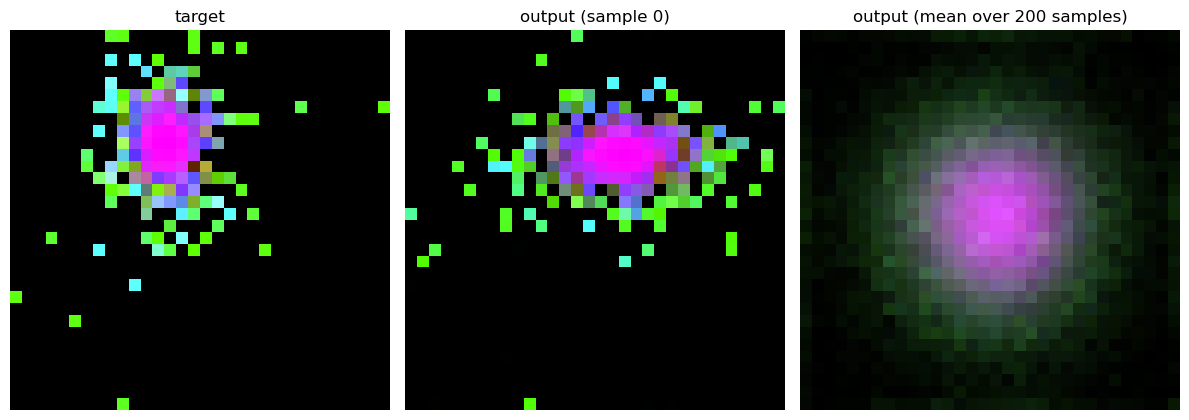

In [ ]:
import matplotlib.pyplot as plt

# plot output and target values as 3 color images
def hwc_from_chw(x):
    # x: (3, H, W) -> (H, W, 3)
    return np.transpose(x, (1, 2, 0))

def normalize01(img):
    mn, mx = img.min(), img.max()
    if mx > mn:
        return (img - mn) / (mx - mn)
    return img - mn  # all zeros case

target_img = normalize01(hwc_from_chw(bundle_dict['target']))
output_arr = bundle_dict['output']  # shape (N, 3, H, W)

# pick the first generated sample to display
out_img0 = normalize01(hwc_from_chw(output_arr[0]))
out_img_mean = normalize01(hwc_from_chw(output_arr.mean(axis=0)))

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(target_img)
axs[0].set_title("target")
axs[0].axis("off")

axs[1].imshow(out_img0)
axs[1].set_title("output (sample 0)")
axs[1].axis("off")

axs[2].imshow(out_img_mean)
axs[2].set_title("output (mean over 200 samples)")
axs[2].axis("off")

plt.tight_layout()
